# Modular Multi-Iteration Comparison between FedAVG and our Linear Regression Federated algorithm

In this notebook you can perform a comparison between the two algorithms over an average of different executions (*iterations*) over the same task.

A synthetic dataset is recreated at each iteration, keeping the parameters to be estimated unchanged.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import os
import numpy as np
import math

from Stationary.core import *
from Stationary.utils import *

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt



np.random.seed(0)
torch.manual_seed(0)

## Neural Network model for FedAVG

In [4]:
import torch.nn.functional as F
import copy

class customModel(torch.nn.Module):
    
    def __init__(self, inputSize, outputSize, H = 10):
        
        super(customModel, self).__init__()
        self.linear = torch.nn.Linear(inputSize, H, bias=True)
        self.linear2 = torch.nn.Linear(H, outputSize)

        
    def forward(self, x):
        x = self.linear(x)
        x = self.linear2(x)
        return x

## Parameters

In [16]:
#-----Federated Parameters
num_workers = 16
num_rounds = 30


#-----Linear Regression Parameters
m = -2.1
m2 = 1.4
m3 = -0.5
c = 1.4
v = 20    #noise variance
range_min = 0    #min value of X
range_max = 10    #max value of X
dataset_size = 6000    #dataset size



#-----FedAVG Parameters
learning_rate = 1e-4
local_epochs = 500
lr_gamma = 0.7


#-----Execution Parameters
iterations = 1
train_percentage = 0.8

In [17]:
from collections import defaultdict

### Lists to keep track of the losses and scores during multiple iterations
error_list = []
score_list = []
error_list_fedavg = []
score_list_fedavg = []


### ITERATIONS: at each iteration, a new dataset is generated
for iteration in range(0, iterations):

    print("---------- ITERATION N° {}".format(iteration+1))
    
    ### Dataset Creation
    ''' Comment one of the two dataset creation sections'''
    
    ###### One Feature Dataset
    
    dataset_X = np.linspace(range_min, range_max, dataset_size)
    np.random.shuffle(dataset_X)
    
    dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(v)

    dataset_X = dataset_X.reshape(-1,1)
    dataset_y = dataset_y.reshape(-1,1)
    
    
    
    
    ###### Three Feature Dataset
    
    '''
    dataset_X1 = np.linspace(range_min, range_max, dataset_size)
    dataset_X2 = np.linspace(range_min, range_max, dataset_size)
    dataset_X3 = np.linspace(range_min, range_max, dataset_size)

    np.random.shuffle(dataset_X1)
    np.random.shuffle(dataset_X2)
    np.random.shuffle(dataset_X3)

    dataset_X = np.array([dataset_X1, dataset_X2, dataset_X3])
    dataset_y = dataset_X1 * m + dataset_X2 * m2 + dataset_X3 * m3 + c + np.random.randn(dataset_X1.size) * math.sqrt(v)
    dataset_y = dataset_y.reshape(-1,1)
    dataset_X = dataset_X.transpose()
    
    '''
    
    ''' 
    Splitting the dataset in lists of training sets:
    One for each round, for each worker  
    '''
    train_X, test_X = np.split(dataset_X, 
                [int(train_percentage * len(dataset_X))
                ])

    train_y, test_y = np.split(dataset_y, 
                [int(train_percentage * len(dataset_y))
                ])
    
    train_list_X = splitDataset(train_X, num_workers, num_rounds)
    train_list_y = splitDataset(train_y, num_workers, num_rounds)
    
    
    
    ### OUR ALGORITHM OLS - INITIALIZATION
    
    worker_list = []
    
    for i in range(0, num_workers):
        worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))
        
    server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)
    

    # stores losses trend for each worker along epochs
    worker_losses_dict = defaultdict(list)

    error = []
    score = []
    

    ### OUR ALGORITHM OLS - EXECUTION

    for i in range(0, num_rounds):

        for j in range(0, num_workers):

            worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])
            pred_worker = worker_list[j].evaluate(test_X)

            # store loss info for current epoch 
            worker_losses_dict[j].append(mean_squared_error(test_y, pred_worker))

        server.aggregation() 
        server.return_to_workers()

        pred_server = server.evaluate(test_X)
        error.append(mean_squared_error(test_y, pred_server))
        score.append(r2_score(test_y, pred_server))
        
    error_list.append(error)
    score_list.append(score)
    
    
    
    ### Dataset modification
    '''input data for the FedAVG Neural Network'''
    
    from torch.autograd import Variable

    for i in range(0, len(train_list_X)):
        train_list_X[i] = torch.from_numpy(train_list_X[i])

    for i in range(0, len(train_list_y)):
        train_list_y[i] = torch.from_numpy(train_list_y[i])
    
    
    ### FEDAVG - INITIALIZATION
    
    ''' Neural Network creation. w: set of neural networks, one for each worker'''
    w = []
    w.append(customModel(dataset_X[0].size, dataset_y[0].size))
    for i in range(1, num_workers):
        w.append(copy.deepcopy(w[0]))
    
    '''Sets of losses and optimizers'''
    criterion = []
    optimizers = []
    for i in w:
        criterion.append(torch.nn.MSELoss()) 
        optimizers.append(torch.optim.lr_scheduler.StepLR(torch.optim.SGD(i.parameters(), lr=learning_rate),
                                                          step_size = local_epochs,
                                                          gamma=lr_gamma))
        
    '''Keep track of NN parameters: FedAVG computes the mean of received parameters'''
    params = []
    for i in w:
        params.append(list(i.parameters()))
        
    for model in w:
        model.train()
    
    # stores losses trend for each worker along epochs
    worker_losses_dict = defaultdict(list)
    
    error_fedavg = []
    score_fedavg = []

    
    ### FEDAVG - EXECUTION
    
    for i in range(0, num_rounds):

        for j in range(0, num_workers):

            for epoch in range(local_epochs):
                
                '''Standard PyTorch Execution for local worker'''
                optimizers[j].optimizer.zero_grad()
                loss = 0

                for x in range(len(train_list_X[i*num_workers+j])):
                    inputs = (train_list_X[i*num_workers+j][x]).float()
                    inputs = inputs.unsqueeze(0)
                    labels = (train_list_y[i*num_workers+j][x]).float()
                    labels = labels.unsqueeze(0)
                    y_pred = w[j](inputs)
                    loss += criterion[j](y_pred, labels)

                # store loss info for current epoch 
                worker_losses_dict[j].append(loss)

                loss.backward()
                optimizers[j].optimizer.step()
                optimizers[j].step()
        
        
        '''
            Keep track of local parameters
        '''
        params = []
        for i in w:
            params.append(list(i.parameters()))
            
        new_params = list()
        
        
        
        
        with torch.no_grad():
            
            '''
                new_params contains the set of new aggregated/averaged parameters 
            '''
            for param_i in range(len(params[0])):

                spdz_params = list()

                for remote_index in range(len(w)):
                    spdz_params.append(params[remote_index][param_i])

                spdz = torch.tensor([0.0]).float()

                for k in spdz_params:
                    spdz = spdz + k

                new_param = (spdz) / len(w)
                new_params.append(new_param)

            '''
                Save the new calculated parameters in all the local models
            '''
        
            for remote_index in range(len(w)):
                param_index = 0
                for p in w[remote_index].parameters():
                    p.data = new_params[param_index].data.detach().clone()
                    param_index += 1
    
        '''
            Test prediction with new parameters
                Here we predict with the first worker, but it is totally indifferent since all the workers have
            the same parameters 
        '''
        predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()

        error_fedavg.append(mean_squared_error(test_y, predicted))
        score_fedavg.append(r2_score(test_y, predicted))
    
    
    error_list_fedavg.append(error_fedavg)
    score_list_fedavg.append(score_fedavg)

---------- ITERATION N° 1


In [18]:
err = []
for i in range(0, len(error_list[0])):
    s = 0
    for k in error_list:
        s += k[i]
    err.append(s / len(error_list))


sc = []
for i in range(0, len(score_list[0])):
    s = 0
    for k in score_list:
        s += k[i]
    sc.append(s / len(score_list))


err_s = []
for i in range(0, len(error_list_fedavg[0])):
    s = 0
    for k in error_list_fedavg:
        s += k[i]
    err_s.append(s / len(error_list_fedavg))


sc_s = []
for i in range(0, len(score_list_fedavg[0])):
    s = 0
    for k in score_list_fedavg:
        s += k[i]
    sc_s.append(s / len(score_list_fedavg))

<Figure size 720x360 with 0 Axes>

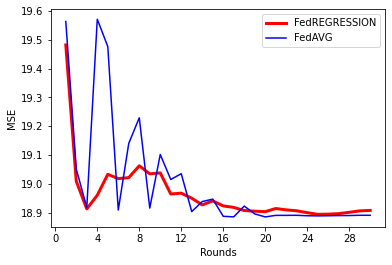

In [19]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

figure(figsize=(10,5))

x = np.arange(1, 1+num_rounds)

ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

#ax.set_ylim(ymin=3, ymax=7)

plt.plot(x, err, color='red', label='FedREGRESSION', linewidth=3)
plt.plot(x, err_s, color='blue', label='FedAVG')
plt.legend(loc='best')

ax.set_xlabel("Rounds")
ax.set_ylabel("MSE")

plt.draw()

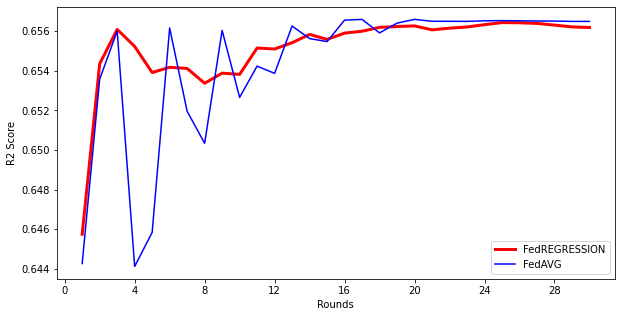

In [20]:
figure(figsize=(10,5))

x = np.arange(1, 1+num_rounds)

plt.plot(x, sc, color='red',label='FedREGRESSION', linewidth=3)
plt.plot(x, sc_s, color='blue', label='FedAVG')

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

#ax.set_ylim(ymin=0.7, ymax=0.9)

ax.set_xlabel("Rounds")
ax.set_ylabel("R2 Score")
plt.legend(loc='best')

plt.draw()

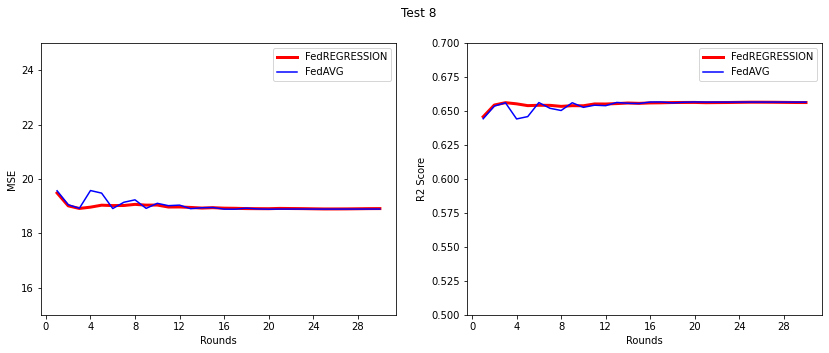

In [23]:
#plt.figure(figsize=(20,5))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Test 8')


x = np.arange(1, 1+num_rounds)

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))


ax1.plot(x, err, color='red', label='FedREGRESSION', linewidth=3)
ax1.plot(x, err_s, color='blue', label='FedAVG')
ax1.legend(loc='best')

ax1.set_xlabel("Rounds")
ax1.set_ylabel("MSE")

ax1.set_ylim(ymin=15, ymax=25)





ax2.plot(x, sc, color='red', label='FedREGRESSION', linewidth=3)
ax2.plot(x, sc_s, color='blue', label='FedAVG')
ax2.legend(loc='best')

ax2.set_xlabel("Rounds")
ax2.set_ylabel("R2 Score")

ax2.set_ylim(ymin=0.5, ymax=0.7)




plt.draw()

plt.savefig("Linear_Tests/test8.svg")

In [27]:
sc_s

[0.6442665144391969,
 0.6535803209307876,
 0.6560044382349095,
 0.6441206734050993,
 0.6458418603394729,
 0.6561636524533514,
 0.6519558556926291,
 0.6503418113543654,
 0.6560416114300567,
 0.6526592712037929,
 0.6542378886286029,
 0.6538724757095442,
 0.6562637119098365,
 0.6556292853641352,
 0.6554778288128988,
 0.6565612986607423,
 0.6565974719924377,
 0.6559168721153943,
 0.6564098831822877,
 0.6566004083056036,
 0.6565031397600058,
 0.6565020746679209,
 0.6564984098397576,
 0.6565266978970932,
 0.6565357298741428,
 0.6565270871258908,
 0.6565159435954189,
 0.6565134807409083,
 0.6564967630949394,
 0.6564973843260735]